# Import the necessary dependencies 

### Setting TensorFlow 2.x as default version 

In [0]:
try:
    %tensorflow_version 2.x
except Exception:
    pass

import tensorflow as tf

### Importing the Visualisation and Preprocessing packages

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import cv2

import numpy as np
import pandas as pd
import pickle

import random


### Importing the TensorFlow dependencies

In [0]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Dropout,Flatten
from tensorflow.keras.layers import BatchNormalization,Conv2D,MaxPooling2D
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

# Data loading and Visualisation 

### Loading the data

In [0]:
#data = pd.read_csv("german-traffic-signs / signnames.csv") 
  
with open('/content/drive/My Drive/Traffic_sign_Dataset/train.p', 'rb') as f: 
    train_data = pickle.load(f) 
with open('/content/drive/My Drive/Traffic_sign_Dataset/valid.p', 'rb') as f: 
    val_data = pickle.load(f) 
with open('/content/drive/My Drive/Traffic_sign_Dataset/test.p', 'rb') as f: 
    test_data = pickle.load(f) 

# Extracting the labels from the dictionaries 
x_train, y_train = train_data['features'], train_data['labels'] 
x_val, y_val = val_data['features'], val_data['labels'] 
x_test, y_test = test_data['features'], test_data['labels'] 

print(x_train.shape) 
print(x_val.shape) 
print(x_test.shape) 

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


### Visualising the Image data

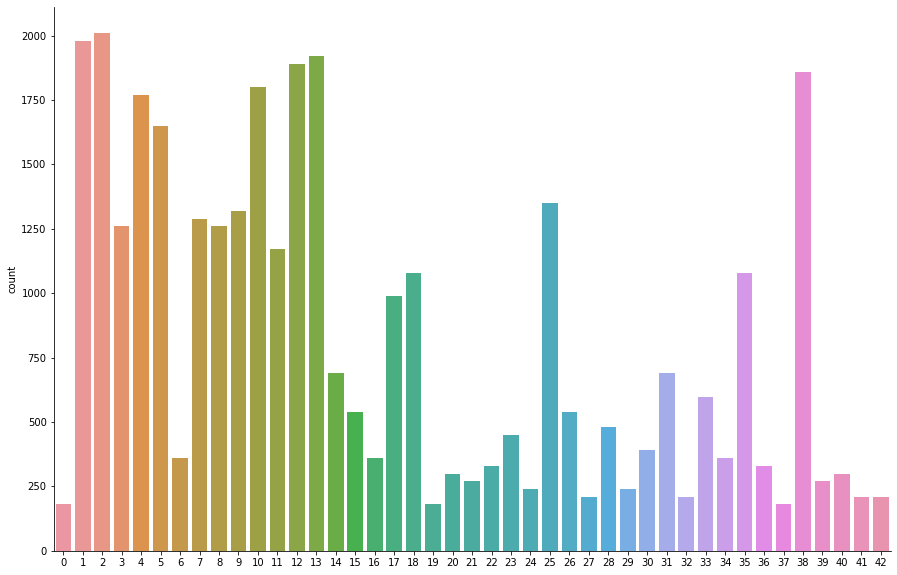

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15,10))
sns.countplot(x="labels", data=train_data)
sns.despine()

# Image Processing & Image Augmentation

### Pre-processing the images using OpenCV

In [0]:
def preprocessing(img): 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    img = cv2.equalizeHist(img) 
    img = img / 255
    return img 
  
x_train_final = np.array(list(map(preprocessing, x_train))) 
x_val_final = np.array(list(map(preprocessing, x_val))) 
x_test_final = np.array(list(map(preprocessing, x_test))) 
  
x_train_final = x_train_final.reshape(34799, 32, 32, 1) 
x_val_final = x_val_final.reshape(4410, 32, 32, 1) 
x_test_final = x_test_final.reshape(12630, 32, 32, 1) 


### Image Augmentation using ImageDataGenerator

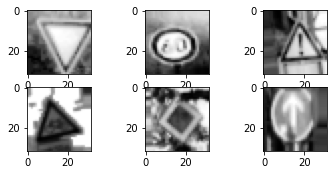

In [0]:

datagen = ImageDataGenerator(width_shift_range = 0.1,  
                  height_shift_range = 0.1,  
                  zoom_range = 0.2,  
                  shear_range = 0.1,  
                  rotation_range = 10) 

datagen.fit(x_train_final) 

#os.makedirs('/content/drive/My Drive/Traffic_sign_Dataset/images')

for x_batch,y_batch in datagen.flow(x_train_final,y_train,batch_size=6,save_to_dir='/content/drive/My Drive/Traffic_sign_Dataset/images',save_prefix='img', save_format='jpg'):
    for i in range(0, 6):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(32, 32), cmap=plt.get_cmap('gray'))

    plt.show()
    break

y_train = to_categorical(y_train, 43) 
y_val = to_categorical(y_val, 43) 
y_test = to_categorical(y_test, 43) 


# Model Building and Testing 

### Implementing the CNN Model 

In [0]:
def build_model(hp):
    model = Sequential()

    # Layer 1 
    model.add(Conv2D(filters=hp.Int('CONV_1_FILTER',min_value=32, max_value=64),
                     kernel_size=hp.Choice('KERNEL_1_FILTER', values=[3,5]),
                     activation='relu',
                     input_shape=(32,32,1), 
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_1', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    # Layer 2 
    model.add(Conv2D(filters=hp.Int('CONV_2_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_2_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))


    # Layer 3
    model.add(Conv2D(filters=hp.Int('CONV_3_FILTER',min_value=32, max_value=128),
                     kernel_size=hp.Choice('KERNEL_3_FILTER', values=[3,5]),
                     activation='relu',
                     padding='same',
                     kernel_regularizer = l2(0.0005)
                     ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(hp.Float('DROPOUT_3', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    
    model.add(Flatten())

    
    model.add(Dense(hp.Int('DENSE_1_LAYER', 
                           min_value=32, 
                           max_value=512),
                    
                    activation = hp.Choice(
                    'dense_activation',
                    values=['relu', 'tanh', 'sigmoid'],
                    default='relu')
    ))
    model.add(Dropout(hp.Float('DROPOUT_2', min_value=0.0,max_value=0.5,default=0.25,step=0.05)))

    model.add(Dense(43, activation='softmax'))

    # Learning Rate set between 0.0001 to 0.01
    model.compile(Adam(hp.Float(
                    'learning_rate',
                    min_value=1e-4,
                    max_value=1e-2,
                    sampling='LOG')),
                    loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model
    

### Install Kerastuner

In [0]:
!pip install keras-tuner

### Use RandomSearch using keraatuner to find the best hyperparameters

In [0]:
from kerastuner import RandomSearch

In [0]:
tuner = RandomSearch(build_model, objective='val_accuracy',
                     max_trials = 10, 
                     directory='/content/drive/My Drive/Traffic_sign_Dataset',
                     project_name="Traffic_Sign_Classifier")

INFO:tensorflow:Reloading Oracle from existing project /content/drive/My Drive/Traffic_sign_Dataset/Traffic_Sign_Classifier/oracle.json
INFO:tensorflow:Reloading Tuner from /content/drive/My Drive/Traffic_sign_Dataset/Traffic_Sign_Classifier/tuner0.json


In [0]:
tuner.search_space_summary()

In [0]:
tuner.search(x_train_final,y_train,epochs=10, validation_data=(x_val_final,y_val))

INFO:tensorflow:Oracle triggered exit


### Get the best model

In [0]:
final_model = tuner.get_best_models(num_models=1)[0]

In [0]:
final_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        480       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 92)        110492    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 92)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 92)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 127)         2

### Creating a Model Checkpoint

In [0]:
filepath="/content/drive/My Drive/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5"
checkpoint_conv = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list_conv = [checkpoint_conv]

### Fit the model

In [0]:
BATCH_SIZE = 100
EPOCHS = 40

In [0]:
history = final_model.fit(
                            datagen.flow(x_train_final, y_train, batch_size=BATCH_SIZE), 
                            steps_per_epoch = int(np.ceil(len(x_train_final)/float(BATCH_SIZE))), 
                            epochs = EPOCHS, 
                            validation_data =(x_val_final, y_val),
                            shuffle = True,
                            callbacks=callbacks_list_conv
                          )


Epoch 1/40
348/348 [==============================] - ETA: 0s - loss: 0.8921 - accuracy: 0.7859
Epoch 00001: val_accuracy improved from -inf to 0.96463, saving model to /content/drive/My Drive/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5
348/348 [==============================] - 15s 42ms/step - loss: 0.8921 - accuracy: 0.7859 - val_loss: 0.2930 - val_accuracy: 0.9646
Epoch 2/40
347/348 [============================>.] - ETA: 0s - loss: 0.6854 - accuracy: 0.8429
Epoch 00002: val_accuracy did not improve from 0.96463
348/348 [==============================] - 12s 36ms/step - loss: 0.6854 - accuracy: 0.8429 - val_loss: 0.2885 - val_accuracy: 0.9637
Epoch 3/40
348/348 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.8646
Epoch 00003: val_accuracy improved from 0.96463 to 0.96735, saving model to /content/drive/My Drive/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5
348/348 [==============================] - 14s 41ms/step - loss: 0.6061 - accuracy: 0.

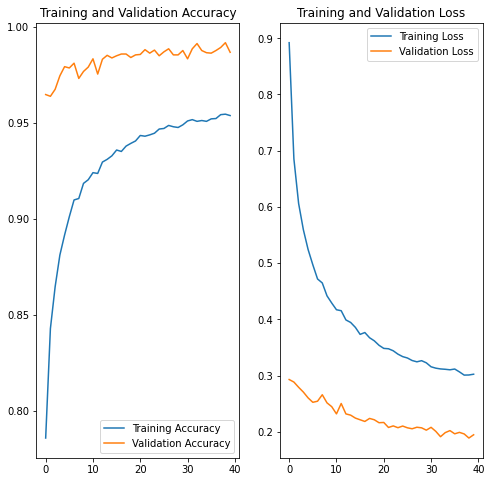

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Load the model's weights and biases for evaluation on Test set

In [0]:
final_model.load_weights("/content/drive/My Drive/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5")
final_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
Pred_conv = final_model.evaluate(x_test_final, y_test, verbose=0)
print("Results on the test data")
print(" ")
print("%s- %.2f" % (final_model.metrics_names[0], Pred_conv[0]))
print("%s- %.2f" % (final_model.metrics_names[1], Pred_conv[1]))

Results on the test data
 
loss- 0.28
accuracy- 0.97


### Testing the model on the test dataset

Predicted sign: [[5.95169203e-09 1.33304857e-05 4.64417589e-08 8.22311179e-08
  1.00793041e-10 1.53776520e-04 9.99824703e-01 1.95149958e-08
  9.73634437e-11 8.61657005e-14 1.12300655e-10 1.48708246e-08
  1.76557158e-10 6.37280367e-11 4.33579648e-12 4.28027941e-14
  4.16811075e-09 4.14768914e-13 1.11137002e-10 2.02223966e-13
  8.41277603e-11 2.09324294e-11 1.93099575e-14 1.83566842e-11
  1.35439901e-12 2.13375024e-08 3.83618638e-15 9.25231853e-12
  1.41590586e-10 1.22658272e-10 1.58779621e-08 3.06943387e-10
  1.85403493e-07 4.32619947e-11 1.45089789e-12 2.15373902e-13
  8.96582461e-12 1.05680924e-11 1.87089766e-09 6.98752445e-11
  7.32631733e-10 4.96747754e-09 7.83890482e-06]]
---------------------------------------------------------------------------
Predicted Sign[0]


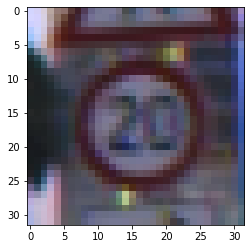

In [0]:

plt.imshow(x_test[990]) 
print("Predicted sign: "+ str( 
        final_model.predict(x_test_final[1700].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(final_model.predict_classes(x_test_final[990].reshape(1, 32, 32, 1))))


### Save the model

In [0]:
final_model.save('/content/drive/My Drive/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5')

### Loading the saved model 

In [0]:
loaded_model = tf.keras.models.load_model('/content/drive/My Drive/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5')

loaded_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 48)        480       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 92)        110492    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 92)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 92)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 127)         2

### Making predictions with the loaded model 

Predicted sign: [[3.4522889e-09 3.0688585e-05 1.5866694e-04 6.6440302e-04 9.7419296e-08
  9.9902177e-01 2.3465546e-07 1.2172624e-04 3.9090730e-07 6.0086491e-10
  1.9281763e-06 3.9314019e-10 1.6360911e-10 1.6927328e-11 9.1467207e-12
  4.2105062e-09 1.8575383e-09 6.3886010e-14 8.1647151e-13 6.6127317e-13
  1.0216057e-11 8.7105871e-11 6.1265622e-14 1.7995303e-12 1.5983633e-12
  4.2088120e-09 1.9983780e-13 1.0291361e-13 1.2473573e-11 3.9872386e-10
  1.2319692e-08 1.6544118e-09 1.6150135e-11 5.6740823e-10 4.3921977e-11
  3.0515163e-11 2.1255560e-12 2.0931132e-12 7.5120399e-09 3.6280859e-12
  1.9607171e-09 3.6935528e-15 8.9487511e-09]]
---------------------------------------------------------------------------
Predicted Sign[5]


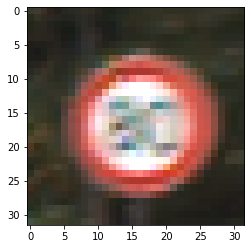

In [0]:
plt.imshow(x_test[1832]) 
print("Predicted sign: "+ str( 
        loaded_model.predict(x_test_final[1832].reshape(1, 32, 32, 1))))

print('---------------------------------------------------------------------------')

print("Predicted Sign" + str(loaded_model.predict_classes(x_test_final[1832].reshape(1, 32, 32, 1))))

### Testing our saved model on random traffic sign images





In [0]:
from tensorflow.keras.models import load_model

import cv2

import numpy as np

final_model = load_model('/content/drive/My Drive/Traffic_sign_Dataset/Traffic_Sign_Classifier_CNN.hdf5')

img = cv2.imread('/content/drive/My Drive/Traffic_sign_Dataset/Test Random Images/go straight or right.png')

img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

img = img / 255

img = cv2.resize(img,(32,32))

img = np.reshape(img,[1,32,32,1])

classes = final_model.predict_classes(img)

print(classes)

[36]
